# GTEx Analysis

In [1]:
import glob
import os
import random

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import fisher_exact
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline

outdir = os.path.join(ciepy.root, 'output',
                      'gtex_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gtex_analysis')
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
rna_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv'),
                         index_col=0)

In [4]:
url = ('ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/'
       'GEUV/E-GEUV-1/analysis_results/EUR373.gene.cis.FDR5.all.rs137.txt.gz')
fn = os.path.join(private_outdir, 'EUR373.gene.cis.FDR5.all.rs137.txt')
if not os.path.exists(fn):
    !curl {url} > {fn + '.gz'}
    !gunzip {fn + '.gz'}

From the GTEx supplement: "For a given tissue, genes having at least 0.1 RPKM in 2 or more individuals were retained."
All of the expression matrices only include genes that pass this filter. So I think they tested
all genes in their expression matrices for eQTLs.

In [5]:
# Single tissue results.
fns = glob.glob('/publicdata/gtex_v6/*.snpgenes')
gtex_results = {}
for fn in fns:
    print(os.path.split(fn)[1][:-18])
    gtex_results[os.path.split(fn)[1][:-18]] = pd.read_table(fn, index_col=0,
                                                             low_memory=False)
    
# Single tissue expression matrices.
fns = glob.glob('/publicdata/gtex_v6/*.expr.txt')
gtex_exp = {}
for fn in fns:
    print(os.path.split(fn)[1][:-18])
    gtex_exp[os.path.split(fn)[1][:-18]] = pd.read_table(fn, index_col=0,
                                                         low_memory=False)

Brain_Hippocampus
Nerve_Tibial
Brain_Cortex
Adrenal_Gland
Skin_Not_Sun_Exposed_Suprapubic
Brain_Cerebellum
Cells_Transformed_fibroblasts
Pituitary
Liver
Esophagus_Mucosa
Artery_Tibial
Brain_Cerebellar_Hemisphere
Colon_Transverse
Heart_Atrial_Appendage
Colon_Sigmoid
Artery_Aorta
Pancreas
Muscle_Skeletal
Artery_Coronary
Heart_Left_Ventricle
Esophagus_Gastroesophageal_Junction
Brain_Nucleus_accumbens_basal_ganglia
Brain_Hypothalamus
Ovary
Whole_Blood
Esophagus_Muscularis
Brain_Putamen_basal_ganglia
Adipose_Subcutaneous
Skin_Sun_Exposed_Lower_leg
Stomach
Adipose_Visceral_Omentum
Lung
Thyroid
Brain_Frontal_Cortex_BA9
Breast_Mammary_Tissue
Brain_Anterior_cingulate_cortex_BA24
Testis
Spleen
Prostate
Vagina
Brain_Caudate_basal_ganglia
Cells_EBV-transformed_lymphocytes
Uterus
Small_Intestine_Terminal_Ileum
Brain_Nucleus_accumbens_basal_ganglia
Brain_Putamen_basal_ganglia
Brain_Cerebellar_Hemisphere
Breast_Mammary_Tissue
Stomach
Thyroid
Adipose_Subcutaneous
Heart_Atrial_Appendage
Vagina
Colon_Tr

In [6]:
for k in gtex_results.keys():
    gtex_results[k]['ens_gene_id'] = gtex_results[k]['gene'].apply(lambda x: x.split('.')[0])

In [8]:
geuvadis = pd.read_table(os.path.join(private_outdir, 'EUR373.gene.cis.FDR5.all.rs137.txt'), 
                         low_memory=False)
geuvadis['ens_gene_id'] = geuvadis.GENE_ID.apply(lambda x: x.split('.')[0])

In [9]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)
lead_vars_single.gene_id = lead_vars_single.gene_id.apply(lambda x: x.split('.')[0])
lead_vars_single.index = [x.split('.')[0] for x in lead_vars_single.index]

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
#encode_chip_seq = pd.read_table(fn, index_col=0)
sig = lead_vars[lead_vars.perm_sig == 1]
sig['ens_gene_id'] = sig.gene_id.apply(lambda x: x.split('.')[0])

In [10]:
gtex_info = pd.DataFrame(index=gtex_results.keys())
gtex_info['num_sig_associations'] = [gtex_results[k].shape[0] for k in gtex_info.index]
gtex_info['num_sig_genes'] = [len(set(gtex_results[k].gene)) for k in gtex_info.index]
gtex_info['num_samples'] = [gtex_exp[k].shape[1] for k in gtex_info.index]
gtex_info['num_genes_tested'] = [gtex_exp[k].shape[0] for k in gtex_info.index]

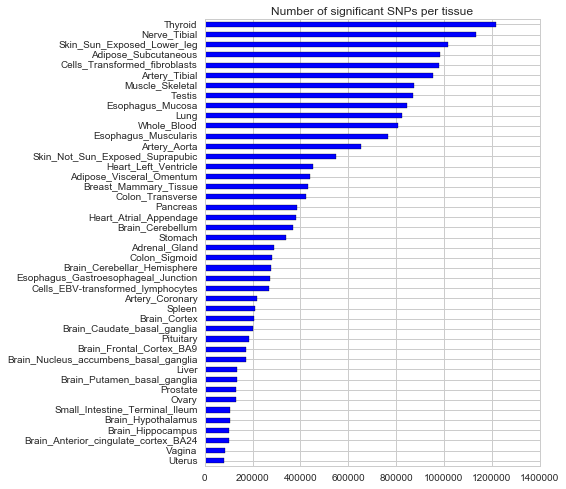

In [11]:
gtex_info.sort_values(by='num_sig_associations', inplace=True)
plt.figure(figsize=(6, 8))
ax = gtex_info.num_sig_associations.plot(kind='barh')
ax.set_title('Number of significant SNPs per tissue');

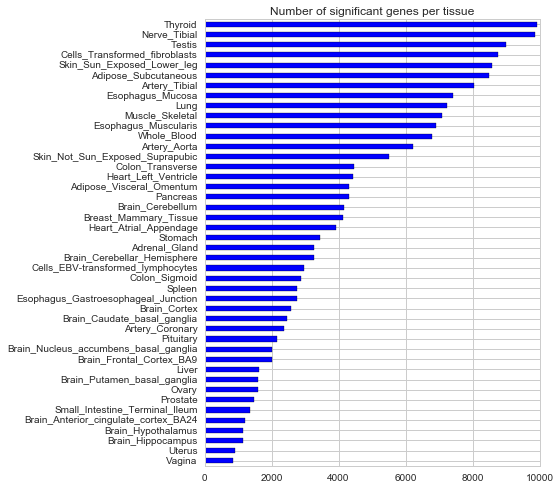

In [12]:
gtex_info.sort_values(by='num_sig_genes', inplace=True)
plt.figure(figsize=(6, 8))
ax = gtex_info.num_sig_genes.plot(kind='barh')
ax.set_title('Number of significant genes per tissue');

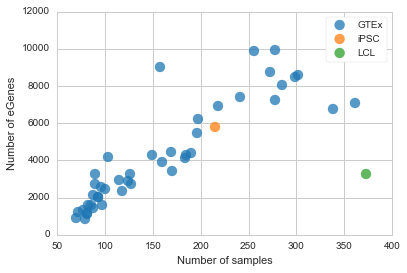

In [13]:
plt.scatter(gtex_info.num_samples, gtex_info.num_sig_genes, label='GTEx', 
            color=cpb.analysis.tableau20[0], s=100, alpha=0.75)
plt.scatter([rna_meta.in_eqtl.sum()], [len(set(sig.gene_id))], label='iPSC', 
            color=cpb.analysis.tableau20[2], alpha=0.75, s=100)
plt.scatter([373], [len(set(geuvadis.GENE_ID))], label='LCL', color=cpb.analysis.tableau20[4],
            alpha=0.75, s=100)

plt.xlabel('Number of samples')
plt.ylabel('Number of eGenes')
plt.legend(frameon=True, fancybox=True)
plt.savefig(os.path.join(outdir, 'samples_vs_egenes.pdf'));

## eQTL sharing

Given that a gene was an eQTL in iPSC, what is the probability 
that it was detected as an eQTL in a different tissue?

In [14]:
vals = []
for k in gtex_results.keys():
    sig_both = set(sig.gene_id) & set(gtex_results[k].gene)
    sig_gtex = set(gtex_results[k].gene) - set(sig.gene_id)
    sig_ipsc = set(sig.gene_id) - set(gtex_results[k].gene)
    tested_both = set(qvalues.index) & set(gtex_exp[k].index) - sig_both
    tested_gtex = set(gtex_exp[k].index) - set(qvalues.index) - sig_gtex
    tested_ipsc = set(qvalues.index) - set(gtex_exp[k].index) - sig_ipsc
    vals.append([len(sig_both), len(sig_gtex), len(sig_ipsc), 
                 len(tested_both), len(tested_gtex), len(tested_ipsc)])
cols = ['sig_both', 'sig_gtex', 'sig_ipsc', 'tested_both', 'tested_gtex', 'tested_ipsc']
df = pd.DataFrame(vals, index=gtex_results.keys(), columns=cols)
gtex_info = gtex_info.join(df)

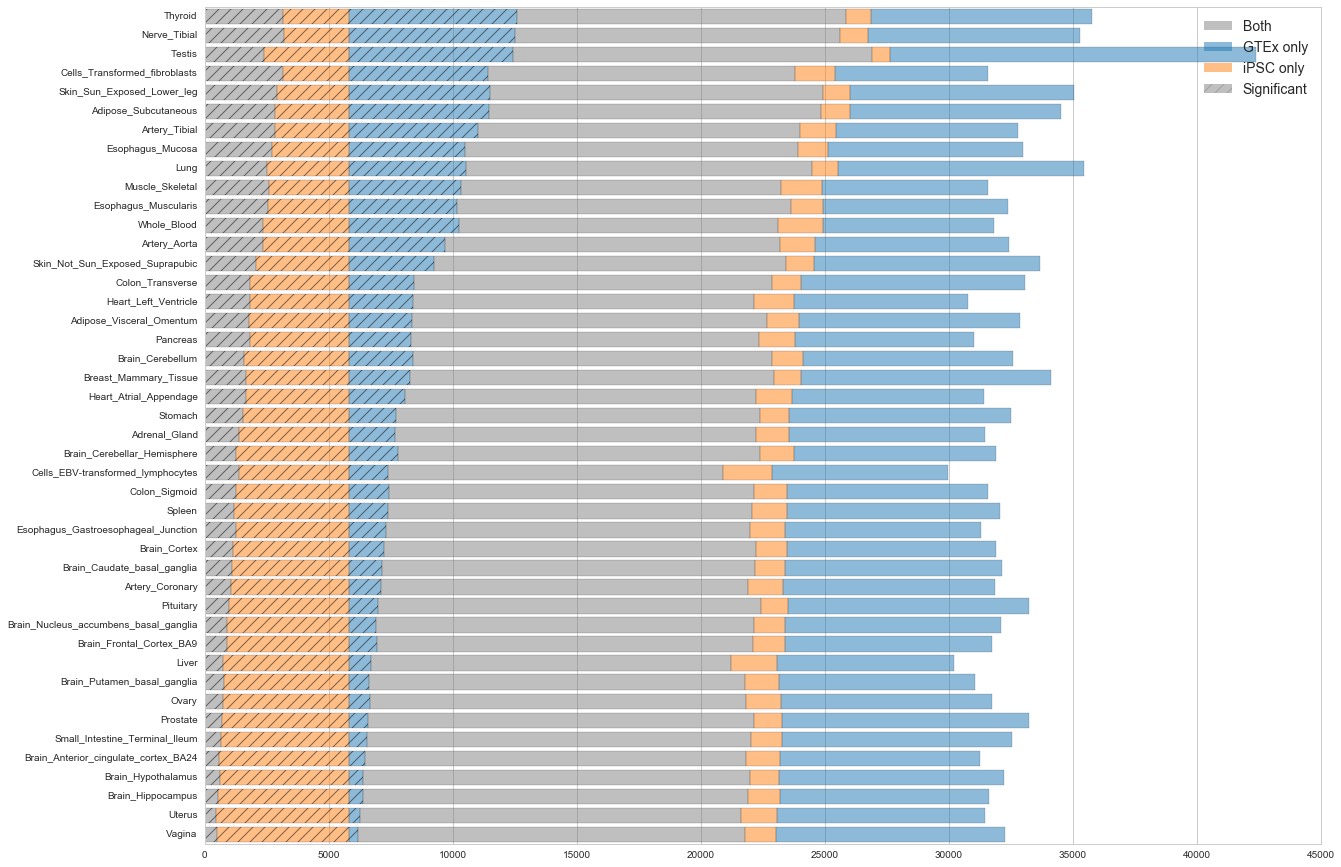

In [15]:
fig,ax = plt.subplots(1, 1, figsize=(20, 15))
left = np.zeros(gtex_info.shape[0])
for c in [u'sig_both', u'sig_ipsc', u'sig_gtex', u'tested_both', 
          u'tested_ipsc', u'tested_gtex']:
    if 'sig' in c:
        hatch = '//'
    else:
        hatch = None
    if 'gtex' in c:
        color = cpb.analysis.tableau20[0]
    elif 'ipsc' in c:
        color = cpb.analysis.tableau20[2]
    else:
        color = 'grey'
    ax.barh(np.arange(gtex_info.shape[0]) + 0.1, gtex_info[c], color=color, 
            alpha=0.5, hatch=hatch, left=left)
    left += gtex_info[c]
ax.set_yticks(np.arange(44) + 0.5)
ax.set_yticklabels(gtex_info.index)
ax.set_ylim(0, 44);

colors = {'Both':'grey', 'GTEx only':cpb.analysis.tableau20[0], 
          'iPSC only':cpb.analysis.tableau20[2]}
rects = []
labels = []
for k in ['Both', 'GTEx only', 'iPSC only']:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=colors[k], alpha=0.5))
labels.append('Significant')
rects.append(plt.Rectangle((0, 0), 0, 0, color='grey', hatch='//', alpha=0.5))
lgd = ax.legend(rects, labels, loc='upper right', fancybox=True, prop={'size':14}) #,ncol=8)
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')

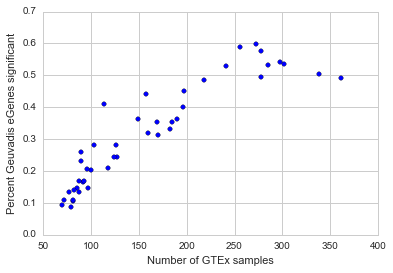

In [24]:
n = float(len(set(geuvadis.GENE_ID)))
gtex_info['percent_geuvadis_in_gtex'] = \
    [len(set(geuvadis.ens_gene_id) & set(gtex_results[k].ens_gene_id)) / n for k in gtex_info.index]

plt.scatter(gtex_info.num_samples, gtex_info.percent_geuvadis_in_gtex)
plt.xlabel('Number of GTEx samples')
plt.ylabel('Percent Geuvadis eGenes significant');

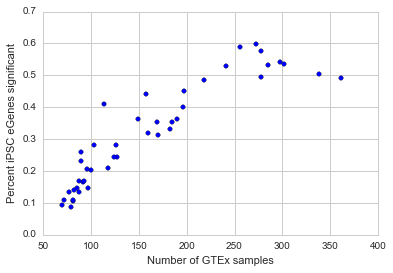

In [25]:
n = float(len(set(sig.gene_id)))
gtex_info['percent_ipsc_in_gtex'] = \
    [len(set(sig.gene_id) & set(gtex_results[k].gene)) / n for k in gtex_info.index]

plt.scatter(gtex_info.num_samples, gtex_info.percent_geuvadis_in_gtex)
plt.xlabel('Number of GTEx samples')
plt.ylabel('Percent iPSC eGenes significant');

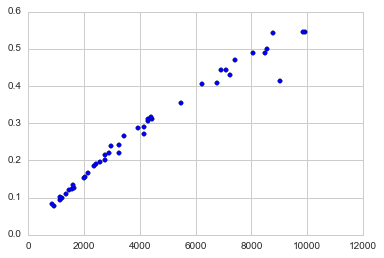

In [26]:
gtex_info.sort_values(by='percent_ipsc_in_gtex', inplace=True)
plt.scatter(gtex_info.num_sig_genes, gtex_info.percent_ipsc_in_gtex)

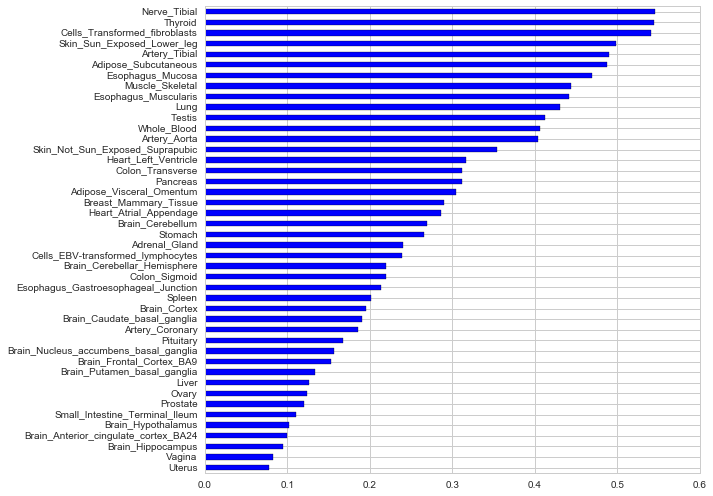

In [27]:
plt.figure(figsize=(10, 7))
gtex_info.percent_ipsc_in_gtex.plot(kind='barh')
plt.tight_layout()

In [28]:
gtex_info['psize'] = gtex_info.num_samples / gtex_info.num_samples.max()

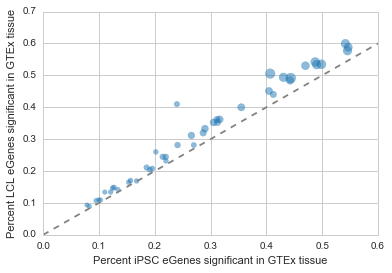

In [29]:
plt.scatter(gtex_info.percent_ipsc_in_gtex, gtex_info.percent_geuvadis_in_gtex,
            color=cpb.analysis.tableau20[0], alpha=0.5, s=gtex_info.psize * 100)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([0, min(xmax, ymax)], [0, min(xmax, ymax)], color='grey', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Percent iPSC eGenes significant in GTEx tissue')
plt.ylabel('Percent LCL eGenes significant in GTEx tissue');

We can see that as a percentage, GTEx tissues recover more of the LCL eGenes.

In [30]:
a = len(set(geuvadis.ens_gene_id) & set(sig.ens_gene_id))
b = len(set(geuvadis.GENE_ID))
c = len(set(sig.gene_id))
print('{:,} iPSC eGenes and {:,} Geuvadis eGenes. {:,} shared.'.format(c, b, a))

5,816 iPSC eGenes and 3,259 Geuvadis eGenes. 1,559 shared.


In [31]:
d = set(geuvadis.ens_gene_id) - set(sig.ens_gene_id)
gtex_info['percent_geuvadis_distinct_in_gtex'] = \
    [len(d & set(gtex_results[k].ens_gene_id)) / float(len(d)) for k in gtex_info.index]
    
d = set(sig.ens_gene_id) - set(geuvadis.ens_gene_id)
gtex_info['percent_ipsc_distinct_in_gtex'] = \
    [len(d & set(gtex_results[k].ens_gene_id)) / float(len(d)) for k in gtex_info.index]

In [32]:
gtex_info[['percent_ipsc_in_gtex', 'percent_geuvadis_in_gtex', 
           'percent_ipsc_distinct_in_gtex', 'percent_geuvadis_distinct_in_gtex']].tail()

,percent_ipsc_in_gtex,percent_geuvadis_in_gtex,percent_ipsc_distinct_in_gtex,percent_geuvadis_distinct_in_gtex
Artery_Tibial,0.490028,0.533599,0.425652,0.412353
Skin_Sun_Exposed_Lower_leg,0.498453,0.534520,0.438807,0.418235
Cells_Transformed_fibroblasts,0.541437,0.599570,0.468640,0.470588
Thyroid,0.545220,0.577171,0.486493,0.459412
Nerve_Tibial,0.546424,0.588217,0.484614,0.471765


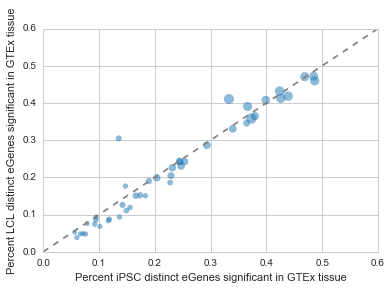

In [33]:
plt.scatter(gtex_info.percent_ipsc_distinct_in_gtex, gtex_info.percent_geuvadis_distinct_in_gtex,
            color=cpb.analysis.tableau20[0], alpha=0.5, s=gtex_info.psize * 100)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([0, min(xmax, ymax)], [0, min(xmax, ymax)], color='grey', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Percent iPSC distinct eGenes significant in GTEx tissue')
plt.ylabel('Percent LCL distinct eGenes significant in GTEx tissue');

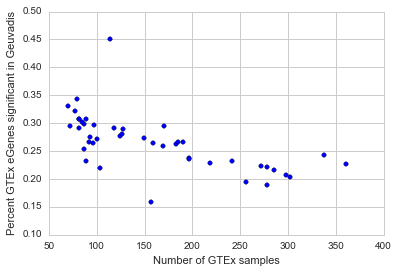

In [34]:
gtex_info['percent_gtex_in_geuvadis'] = \
    [len(set(geuvadis.ens_gene_id) & set(gtex_results[k].ens_gene_id)) / float(len(set(gtex_results[k].gene)))
     for k in gtex_info.index]

plt.scatter(gtex_info.num_samples, gtex_info.percent_gtex_in_geuvadis)
plt.xlabel('Number of GTEx samples')
plt.ylabel('Percent GTEx eGenes significant in Geuvadis');

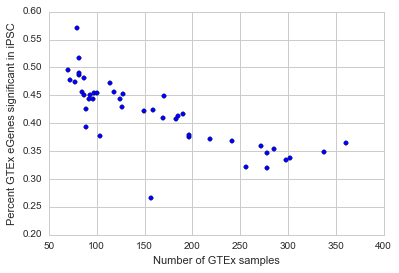

In [35]:
gtex_info['percent_gtex_in_ipsc'] = \
    [len(set(sig.gene_id) & set(gtex_results[k].gene)) / float(len(set(gtex_results[k].gene)))
     for k in gtex_info.index]
    
plt.scatter(gtex_info.num_samples, gtex_info.percent_gtex_in_ipsc)
plt.xlabel('Number of GTEx samples')
plt.ylabel('Percent GTEx eGenes significant in iPSC');

In [36]:
random.seed(20160202)
sample_vals = []
pop = list(set(sig.gene_id))
n = len(set(geuvadis.GENE_ID))
for i in range(100):
    v = []
    samples = set(random.sample(pop, n))
    for k in gtex_results.keys():
        v.append(len(samples & set(gtex_results[k].gene)) / float(len(set(gtex_results[k].gene))))
    sample_vals.append(v)
    
tdf = pd.DataFrame(sample_vals, columns=gtex_results.keys()).T
tdf.columns = ['percent_gtex_in_ipsc_ds_{}'.format(x) for x in tdf.columns]

gtex_info = gtex_info.join(tdf)

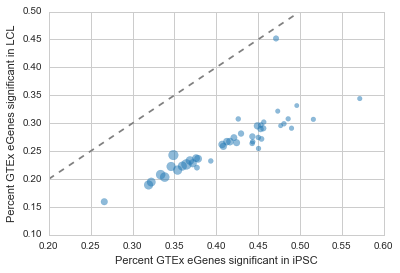

In [38]:
plt.scatter(gtex_info.percent_gtex_in_ipsc, gtex_info.percent_gtex_in_geuvadis,
            color=cpb.analysis.tableau20[0], alpha=0.5, s=gtex_info.psize * 100)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([0, min(xmax, ymax)], [0, min(xmax, ymax)], color='grey', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Percent GTEx eGenes significant in iPSC')
plt.ylabel('Percent GTEx eGenes significant in LCL');

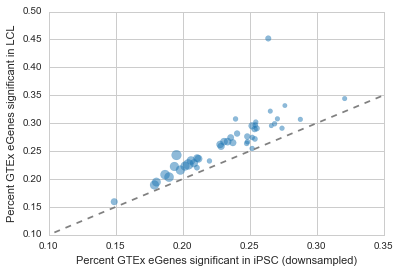

In [40]:
m = gtex_info[['percent_gtex_in_ipsc_ds_{}'.format(x) for x in range(100)]].mean(axis=1)
plt.scatter(m, gtex_info.percent_gtex_in_geuvadis,
            color=cpb.analysis.tableau20[0], alpha=0.5, s=gtex_info.psize * 100)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([0, min(xmax, ymax)], [0, min(xmax, ymax)], color='grey', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Percent GTEx eGenes significant in iPSC (downsampled)')
plt.ylabel('Percent GTEx eGenes significant in LCL');

I'd like to see whether the iPSC eGenes are distinct in some way
compared to GTEx.

In [41]:
gtex_sig_genes = set()
t = []
for k in gtex_results.keys():
    gtex_sig_genes |= set(gtex_results[k].gene)
    t += list(set(gtex_results[k].gene))
gtex_sig_genes_vc = pd.Series(t).value_counts()
gtex_info['num_distinct_egenes'] = \
    [sum(gtex_sig_genes_vc[set(gtex_results[k]['gene'])] == 1) for k in gtex_info.index]
gtex_info.sort_values(by='num_distinct_egenes', inplace=True, ascending=False)

In [42]:
gtex_info.num_sig_genes

Testis                                   9009
Thyroid                                  9937
Nerve_Tibial                             9860
Whole_Blood                              6784
Cells_Transformed_fibroblasts            8760
Esophagus_Mucosa                         7416
Skin_Sun_Exposed_Lower_leg               8567
Adipose_Subcutaneous                     8500
Muscle_Skeletal                          7082
Lung                                     7236
Artery_Tibial                            8056
Esophagus_Muscularis                     6916
Pancreas                                 4301
Artery_Aorta                             6220
Brain_Cerebellum                         4163
Skin_Not_Sun_Exposed_Suprapubic          5491
Colon_Transverse                         4446
Cells_EBV-transformed_lymphocytes        2955
Heart_Left_Ventricle                     4417
Brain_Cerebellar_Hemisphere              3251
Adrenal_Gland                            3259
Heart_Atrial_Appendage            

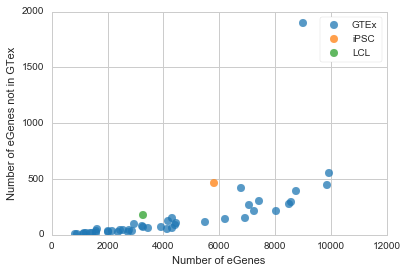

In [43]:
plt.scatter(gtex_info.num_sig_genes, gtex_info.num_distinct_egenes, label='GTEx', 
            color=cpb.analysis.tableau20[0], s=60, alpha=0.75)
plt.scatter([len(set(sig.gene_id))], [len(set(sig.gene_id) - gtex_sig_genes)], label='iPSC', 
            color=cpb.analysis.tableau20[2], alpha=0.75, s=60)
plt.scatter([len(set(geuvadis.ens_gene_id))], [len(set(geuvadis.ens_gene_id) - 
                                                   set([x.split('.')[0] for x in gtex_sig_genes]))],
            label='LCL', color=cpb.analysis.tableau20[4],
            alpha=0.75, s=60)
ymin,ymax = plt.ylim()
plt.ylim(0, ymax)

plt.xlabel('Number of eGenes')
plt.ylabel('Number of eGenes not in GTex')
plt.legend(frameon=True, fancybox=True)
plt.savefig(os.path.join(outdir, 'distinct_egenes.pdf'));

In [52]:
(gtex_info.num_distinct_egenes / gtex_info.num_sig_genes.astype(float)).mean()

0.027031599582848075

In [51]:
[(len(set(sig.gene_id) - gtex_sig_genes)) / 
                                       float(len(set(sig.gene_id)))]

[0.07977991746905089]

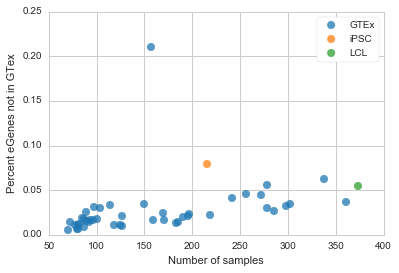

In [44]:
plt.scatter(gtex_info.num_samples, gtex_info.num_distinct_egenes / gtex_info.num_sig_genes.astype(float), 
            label='GTEx', color=cpb.analysis.tableau20[0], s=60, alpha=0.75)
plt.scatter([rna_meta.in_eqtl.sum()], [(len(set(sig.gene_id) - gtex_sig_genes)) / 
                                       float(len(set(sig.gene_id)))], 
            label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=60)
plt.scatter([373], [len(set(geuvadis.ens_gene_id) - set([x.split('.')[0] for x in gtex_sig_genes])) / 
                    float(len(set(geuvadis.ens_gene_id)))],
            label='LCL', color=cpb.analysis.tableau20[4],
            alpha=0.75, s=60)
ymin,ymax = plt.ylim()
plt.ylim(0, ymax)

plt.xlabel('Number of samples')
plt.ylabel('Percent eGenes not in GTex')
plt.legend(frameon=True, fancybox=True)
plt.savefig(os.path.join(outdir, 'distinct_egenes.pdf'));

TODO: Look at EUR population frequency for lead variants. Could rare variants
that are at high frequency in my families be causing this observation?

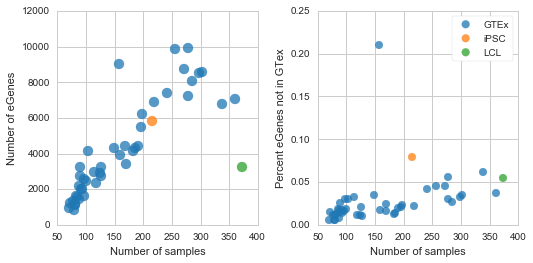

In [45]:
fig,axs = plt.subplots(1, 2, figsize=(7.5, 3.75))
ax = axs[0]
ax.scatter(gtex_info.num_samples, gtex_info.num_sig_genes, label='GTEx', 
            color=cpb.analysis.tableau20[0], s=100, alpha=0.75)
ax.scatter([rna_meta.in_eqtl.sum()], [len(set(sig.gene_id))], label='iPSC', 
            color=cpb.analysis.tableau20[2], alpha=0.75, s=100)
ax.scatter([373], [len(set(geuvadis.GENE_ID))], label='LCL', color=cpb.analysis.tableau20[4],
            alpha=0.75, s=100)

ax.set_xlabel('Number of samples')
ax.set_ylabel('Number of eGenes')


ax = axs[1]
ax.scatter(gtex_info.num_samples, gtex_info.num_distinct_egenes / gtex_info.num_sig_genes.astype(float), 
            label='GTEx', color=cpb.analysis.tableau20[0], s=60, alpha=0.75)
ax.scatter([rna_meta.in_eqtl.sum()], [(len(set(sig.gene_id) - gtex_sig_genes)) / 
                                       float(len(set(sig.gene_id)))], 
            label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=60)
ax.scatter([373], [len(set(geuvadis.ens_gene_id) - set([x.split('.')[0] for x in gtex_sig_genes])) / 
                    float(len(set(geuvadis.ens_gene_id)))],
            label='LCL', color=cpb.analysis.tableau20[4],
            alpha=0.75, s=60)
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

ax.set_xlabel('Number of samples')
ax.set_ylabel('Percent eGenes not in GTex')
ax.legend(frameon=True, fancybox=True)
fig.tight_layout()
plt.savefig(os.path.join(outdir, 'egenes_samples_and_distinct.pdf'));